In [12]:
%matplotlib inline

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [13]:
SNOW_TSV = r"C:\Users\class\Downloads\snowstorm_PA.tsv"
CITY_COUNTY_TSV = r"C:\Users\class\Downloads\PA_cities_counties.tsv"
COUNTY_SHP = r"C:\Users\class\Downloads\tl_2021_us_county\tl_2021_us_county.shp"
MUNI_SHP   = r"C:\Users\class\Downloads\PaMunicipalities2022_01\PaMunicipalities2022_01.shp"

snow = pd.read_csv(SNOW_TSV, sep="\t")
city_cty = pd.read_csv(CITY_COUNTY_TSV, sep="\t")
counties_all = gpd.read_file(COUNTY_SHP)
munis_raw = gpd.read_file(MUNI_SHP)

print("snow cols:", list(snow.columns))
print("city_cty cols:", list(city_cty.columns))
print("counties crs:", counties_all.crs)
print("munis crs:", munis_raw.crs)

snow cols: ['Location', 'Low End Snowfall', 'Expected Snowfall', 'High End Snowfall', 'P>=0.1"', 'P>=1"', 'P>=2"', 'P>=4"', 'P>=6"', 'P>=8"', 'P>=12"', 'P>=18"']
city_cty cols: ['Name', 'Type', 'County', 'Class', 'Population (2018 Estimates)', 'Incorporation date (as city)', 'Sq Miles']
counties crs: EPSG:4269
munis crs: EPSG:3857


In [14]:
def add_area_and_label_coords(gdf):
    gdf["area"] = gdf.geometry.area
    gdf["coords"] = gdf.geometry.apply(lambda x: x.representative_point().coords[:])
    gdf["coords"] = [c[0] for c in gdf["coords"]]

def plot_with_labels(gdf, ax, name_col=None, field_col=None, **kwargs):
    if field_col is None:
        gdf.plot(ax=ax, **kwargs)
    else:
        gdf.plot(column=field_col, ax=ax, legend=True, **kwargs)
    if name_col is not None:
        for _, row in gdf.iterrows():
            ax.annotate(text=row[name_col], xy=row["coords"], ha="center")

def calc_overall_centroid(gdf):
    sum_x = 0.0
    sum_y = 0.0
    sum_a = 0.0
    for _, row in gdf.iterrows():
        x, y = row["coords"]
        a = row["area"]
        sum_x += x * a
        sum_y += y * a
        sum_a += a
    return (sum_x / sum_a, sum_y / sum_a)

def haversine_np(lon1, lat1, lon2, lat2):
    R = 6371.0088
    lon1 = np.radians(lon1); lat1 = np.radians(lat1)
    lon2 = np.radians(lon2); lat2 = np.radians(lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

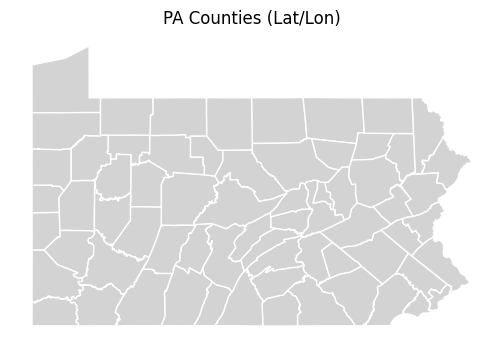

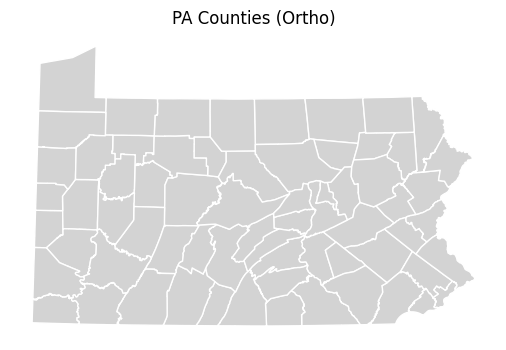

In [15]:
pa = counties_all[counties_all["STATEFP"] == "42"].copy()

pa_ll = pa.to_crs("EPSG:4326")
try:
    center = pa_ll.geometry.union_all().centroid
except Exception:
    center = pa_ll.geometry.unary_union.centroid

lon0, lat0 = float(center.x), float(center.y)

ortho = CRS.from_proj4(
    "+proj=ortho +lat_0={} +lon_0={} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs"
    .format(lat0, lon0)
)

pa_ortho = pa.to_crs(ortho)

fig, ax = plt.subplots(figsize=(7,4))
pa_ll.plot(ax=ax, color="lightgray", edgecolor="white")
ax.set_title("PA Counties (Lat/Lon)")
ax.axis("off")
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
pa_ortho.plot(ax=ax, color="lightgray", edgecolor="white")
ax.set_title("PA Counties (Ortho)")
ax.axis("off")
plt.show()

In [16]:
df = snow.merge(city_cty, how="left", left_on="Location", right_on="Name")

geo = Nominatim(user_agent="ms_das_vis")
geocode = RateLimiter(geo.geocode, min_delay_seconds=1, swallow_exceptions=True)

def county_from_geopy_address(addr):
    # keeps multi-word county names
    if not isinstance(addr, str):
        return None
    parts = [p.strip() for p in addr.split(",")]
    for p in parts:
        # everythg inbefore "County"
        if "County" in p:
            before = p.split("County")[0].strip()
            return before
    return None

need = df["County"].isna()
filled = 0

for idx in df[need].index:
    loc = df.loc[idx, "Location"]
    if pd.isna(loc):
        continue
    hit = geocode(f"{loc} Pennsylvania US")
    if hit is None:
        continue
    cty = county_from_geopy_address(str(hit))
    if cty:
        df.loc[idx, "County"] = cty
        filled += 1

print("filled counties:", filled)
print("still missing:", int(df["County"].isna().sum()))

filled counties: 76
still missing: 1


In [17]:
county_snow = (
    df.dropna(subset=["County"])
      .groupby("County", as_index=False)["Expected Snowfall"]
      .mean()
      .rename(columns={"County": "NAME", "Expected Snowfall": "Estimated Snowfall"})
)

county_snow.head()

,NAME,Estimated Snowfall
0,Allegheny,11.571429
1,Armstrong,9.500000
2,Beaver,12.400000
3,Butler,12.200000
4,Clarion,11.500000


In [18]:
pa_snow = pa_ortho.merge(county_snow, how="left", on="NAME")
pa_snow[["NAME", "Estimated Snowfall"]].head()

,NAME,Estimated Snowfall
0,Beaver,12.4
1,Forest,12.0
2,Tioga,NaN
3,Dauphin,NaN
4,Wayne,NaN


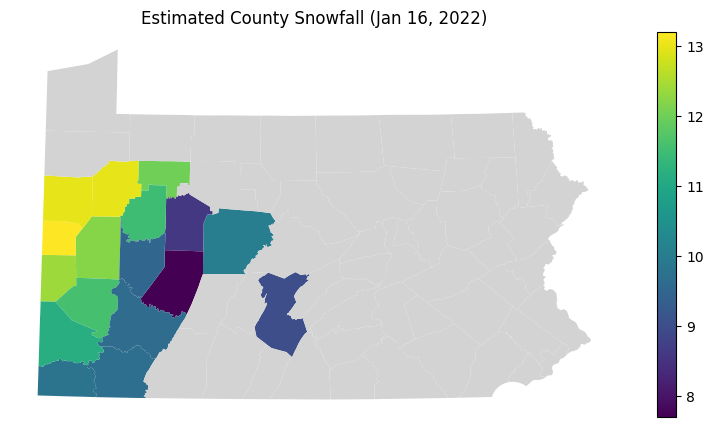

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
pa_snow.plot(
    ax=ax,
    column="Estimated Snowfall",
    legend=True,
    missing_kwds={"color": "lightgray", "label": "No data"},
)
ax.set_title("Estimated County Snowfall (Jan 16, 2022)")
ax.axis("off")
plt.show()

In [20]:
munis_ortho = munis_raw.to_crs(ortho)
munis_ll = munis_raw.to_crs("EPSG:4326")

add_area_and_label_coords(munis_ortho)
add_area_and_label_coords(munis_ll)

# pick a name column
name_col = None
for c in ["MUNICIPALITY", "MUNI_NAME", "MUNICIPAL_NAME", "NAME", "Name", "FIPS_NAME"]:
    if c in munis_ortho.columns:
        name_col = c
        break

print("municipality name column:", name_col)

municipality name column: FIPS_NAME


C:\Users\class\AppData\Local\Temp\ipykernel_31040\2174791252.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["area"] = gdf.geometry.area


missing cities: []


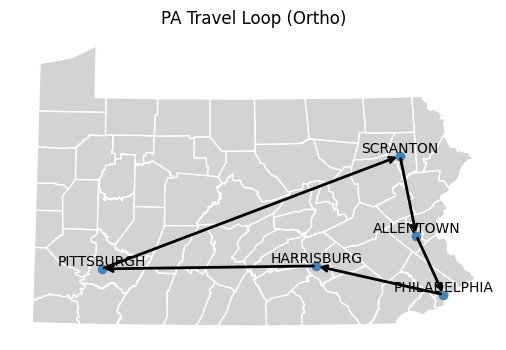

In [21]:
travel_towns = ["Pittsburgh", "Scranton", "Allentown", "Philadelphia", "Harrisburg", "Pittsburgh"]

def norm(s):
    s = str(s).upper()
    s = re.sub(r"[^A-Z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

munis_ortho["_nm"] = munis_ortho[name_col].astype(str).map(norm)

def best_city_poly(city):
    c = norm(city)
    cand = munis_ortho[munis_ortho["_nm"].str.contains(c, na=False)].copy()
    if cand.empty:
        return None
    cand["_a"] = cand.geometry.area
    return cand.sort_values("_a", ascending=False).iloc[0].geometry

geo2 = Nominatim(user_agent="ms_das_vis")
geocode_city = RateLimiter(geo2.geocode, min_delay_seconds=1, swallow_exceptions=True)

def city_point_ortho(city):
    hit = geocode_city(f"{city}, Pennsylvania, US")
    if hit is None:
        return None
    pt_ll = gpd.GeoSeries([gpd.points_from_xy([hit.longitude], [hit.latitude])[0]], crs="EPSG:4326")
    return pt_ll.to_crs(ortho).iloc[0]

city_pts = {}

for c in sorted(set(travel_towns[:-1])):
    poly = best_city_poly(c)
    if poly is not None:
        city_pts[c] = poly.representative_point()
    else:
        city_pts[c] = city_point_ortho(c)

missing = [c for c, p in city_pts.items() if p is None]
print("missing cities:", missing)
if missing:
    raise ValueError("Some travel cities couldn't be found even by geocoder.")

# plot
fig, ax = plt.subplots(figsize=(10,4))
pa_ortho.plot(ax=ax, color="lightgray", edgecolor="white")

pts_gdf = gpd.GeoDataFrame(
    {"city": list(city_pts.keys()), "geometry": list(city_pts.values())},
    crs=ortho
)
pts_gdf.plot(ax=ax, color="steelblue", markersize=35)

for _, r in pts_gdf.iterrows():
    ax.annotate(r["city"].upper(), xy=(r.geometry.x, r.geometry.y), ha="center", va="bottom")

for a, b in zip(travel_towns[:-1], travel_towns[1:]):
    p1 = city_pts[a]
    p2 = city_pts[b]
    ax.annotate(
        "",
        xy=(p2.x, p2.y),
        xytext=(p1.x, p1.y),
        arrowprops=dict(arrowstyle="->", lw=2, color="black"),
    )

ax.set_title("PA Travel Loop (Ortho)")
ax.axis("off")
plt.show()

In [23]:
loop_m = 0.0
for a, b in zip(travel_towns[:-1], travel_towns[1:]):
    seg = gpd.GeoSeries([city_pts[a]], crs=ortho).distance(gpd.GeoSeries([city_pts[b]], crs=ortho)).iloc[0]
    loop_m += float(seg)

print(f"Loop distance (ortho straight-line): {loop_m/1000:.2f} km")

# haversine get lat/lon for each city point by projecting the points to 4326
pts_ll = pts_gdf.to_crs("EPSG:4326")
pt_ll_lookup = dict(zip(pts_ll["city"], pts_ll.geometry))

loop_km = 0.0
for a, b in zip(travel_towns[:-1], travel_towns[1:]):
    p1 = pt_ll_lookup[a]
    p2 = pt_ll_lookup[b]
    loop_km += haversine_np(p1.x, p1.y, p2.x, p2.y)

print(f"Loop distance (haversine lat/lon):   {loop_km:.2f} km")
print("They differ because the ortho distance is a flat, planar straight-line distance in a projected coordinate system, while the haversine distance follows the Earth's curvature using latitude and longitude. Projection distortion and the choice of city center points also cause small differences. It's close though.")



Loop distance (ortho straight-line): 904.63 km
Loop distance (haversine lat/lon):   904.78 km
They differ because the ortho distance is a flat, planar straight-line distance in a projected coordinate system, while the haversine distance follows the Earth's curvature using latitude and longitude. Projection distortion and the choice of city center points also cause small differences.
